In [61]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel

# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["model_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data, string_map


encoded_dataset_name, string_map = string_encode(df["model_name"])
df["model_encoded"] = encoded_dataset_name

node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]
causal_dataset_df = df[node_labels]
df["Temperature"] = df["Temperature"].round(1)
grouped = causal_dataset_df.groupby(["Temperature", "model_encoded"])
train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    train = group.sample(frac=0.8, random_state=42)
    validation = group.drop(train.index)
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")

start = 0.1
stop = 2.1
step = 0.3

# Use numpy.arange to generate the range
control_values = np.arange(start, stop, step)

Train set size: 11858
Validation set size: 2940


In [62]:
unique_temperatures = sorted(validation_set["Temperature"].unique())
unique_models = validation_set["model_encoded"].unique()

results = []
for i in range(len(unique_temperatures) - 1):
    temp = unique_temperatures[i]
    next_temp = unique_temperatures[i + 1]
    for model in unique_models:
        control_df = validation_set[
            (validation_set["Temperature"] == temp)
            & (validation_set["model_encoded"] == model)
        ]
        treatment_df = validation_set[
            (validation_set["Temperature"] == next_temp)
            & (validation_set["model_encoded"] == model)
        ]

        control_measure = control_df["rouge_l_fmeasure"].tolist()
        treatment_measure = treatment_df["rouge_l_fmeasure"].tolist()
        true_effect_list = [
            treatment_measure[i] - control_measure[i]
            for i in range(min(len(control_measure), len(treatment_measure)))
        ]

        for effect in true_effect_list:
            results.append(
                {"Temperature": temp, "model_encoded": model, "true_effect": effect}
            )

true_effect = pd.DataFrame(results)

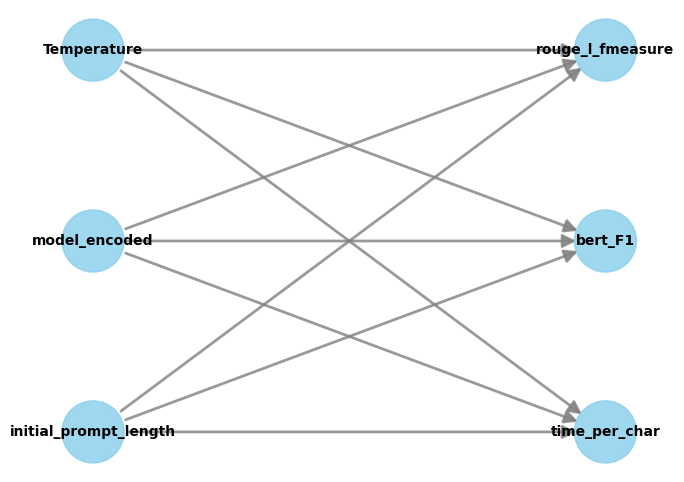

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                            
──────────────(E[rouge_l_fmeasure])
d[Temperature]                     
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→rouge_l_fmeasure then P(rouge_l_fmeasure|Temperature,,U) = P(rouge_l_fmeasure|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [81]:
model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["rouge_l_fmeasure", "bert_F1", "time_per_char"],
    effect_modifiers=["model_encoded", "initial_prompt_length"],
)
model.view_model()

identified_estimand = model.identify_effect()
print(identified_estimand)

In [64]:
# Using linear regression as a test
from lightgbm import LGBMRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV


model_y = LinearRegression(fit_intercept=True)
model_t = LinearRegression(fit_intercept=True)

result_df = pd.DataFrame()
model_list = validation_set["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {
                "model_y": model_y,
                "model_t": model_t,
            }
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=validation_set[
                validation_set["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

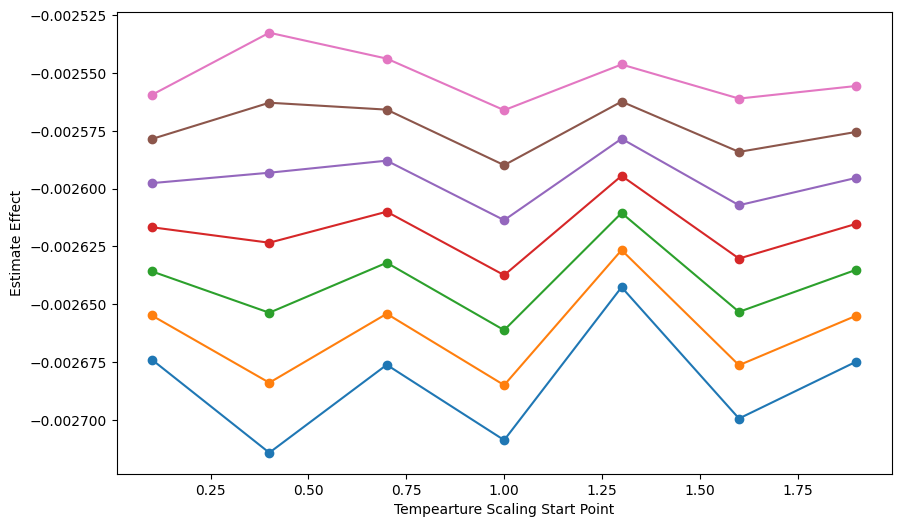

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

model_map = {
    0: "Llama-2-7b-chat-hf",
    1: "Llama-2-13b-chat-hf",
    2: "Mixtral-8x7B-Instruct-v0.1",
    3: "Mistral-7B-Instruct-v0.2",
    4: "Meta-Llama-3-8B-Instruct",
    5: "Meta-Llama-3-70B-Instruct",
    6: "Llama-2-70b-chat-hf",
}
result_df["control_value"] = result_df["control_value"].round(1)
result_df["model_name"] = result_df["model_encoded"].map(model_map)
grouped = result_df.groupby("model_encoded")

plt.figure(figsize=(10, 6))

for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_value"],
        label=model_map[name],
        marker="o",
    )
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)

# plt.legend()

plt.xlabel("Tempearture Scaling Start Point")
plt.ylabel("Estimate Effect")
# plt.title("Estimate Value vs Control Value for Different Model Encodings")

plt.show()

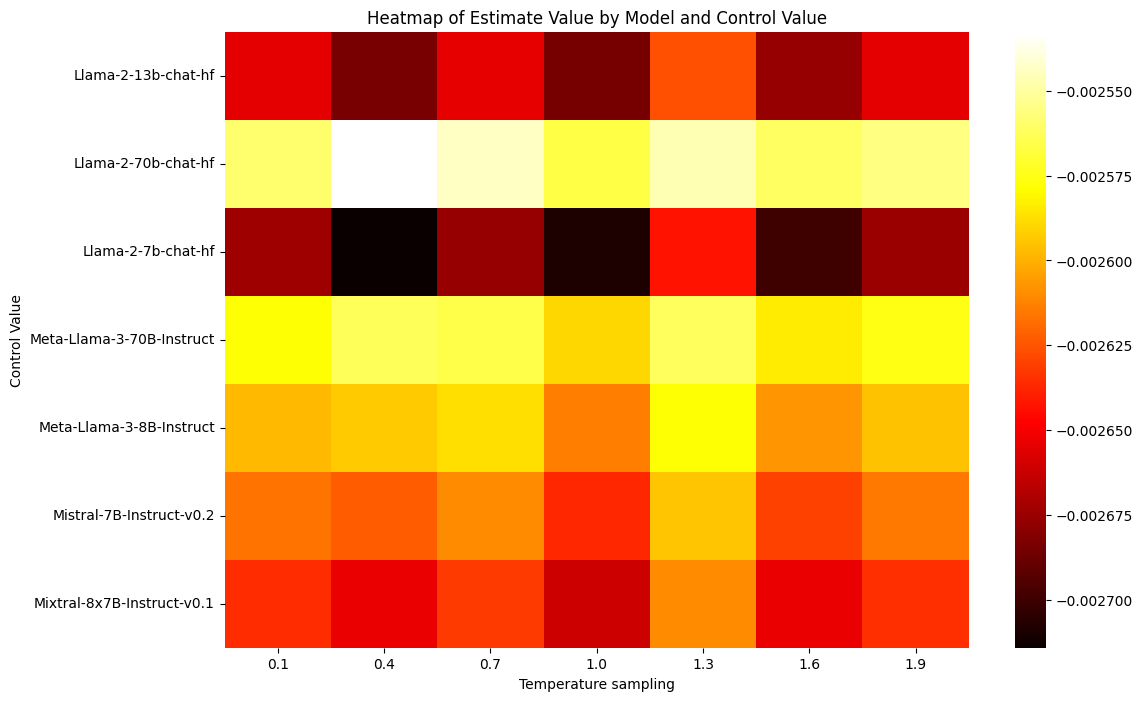

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pivot_table = result_df.pivot_table(
    values="estimate_value", index="model_name", columns="control_value", aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, fmt=".2f", cmap="hot")

plt.xlabel("Temperature sampling")
plt.ylabel("Control Value")
plt.title("Heatmap of Estimate Value by Model and Control Value")

plt.show()

# Modeling With With Gradient Booting Regressor

In [53]:
import pandas as pd
import os
import datetime
import numpy as np
import warnings
from dowhy import CausalModel

# Data Preprocessing
warnings.filterwarnings("ignore")
current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

folder_path = "Paper Experiment Results/New_filtered/Summary"
output_photo_name = f"SUM_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["model_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["pure_response"] = df["pure_response"].astype(str)
df["pure_response_length"] = df["pure_response"].apply(len)
df["time_per_char"] = df["elapsed_time"] / df["pure_response_length"]
df["initial_prompt_length"] = df["initial_prompt"].apply(len)


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data, string_map


encoded_dataset_name, string_map = string_encode(df["model_name"])
df["model_encoded"] = encoded_dataset_name

node_labels = [
    "Temperature",
    "model_encoded",
    "initial_prompt_length",
    "bert_F1",
    "rouge_l_fmeasure",
    "time_per_char",
]
causal_dataset_df = df[node_labels]
df["Temperature"] = df["Temperature"].round(1)
grouped = causal_dataset_df.groupby(["Temperature", "model_encoded"])
train_set = pd.DataFrame()
validation_set = pd.DataFrame()
for name, group in grouped:
    train = group.sample(frac=0.8, random_state=42)
    validation = group.drop(train.index)
    train_set = pd.concat([train_set, train])
    validation_set = pd.concat([validation_set, validation])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(validation_set)}")

start = 0.1
stop = 2.1
step = 0.3

# Use numpy.arange to generate the range
control_values = np.arange(start, stop, step)

Train set size: 11858
Validation set size: 2940


In [54]:
# Model Training
from sklearn.model_selection import GridSearchCV


model = CausalModel(
    data=train_set,
    treatment=["Temperature"],
    outcome=["rouge_l_fmeasure"],
    effect_modifiers=["model_encoded"],
)
identified_estimand = model.identify_effect()
print(identified_estimand)

model_y = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={"max_depth": [3, 10, 20, 100], "n_estimators": [10, 50, 100]},
    cv=10,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
)

model_t = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={"max_depth": [3, 10, 20, 100], "n_estimators": [10, 50, 100]},
    cv=10,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
)

result_df = pd.DataFrame()
model_list = validation_set["model_encoded"].unique().tolist()
for control_value in control_values:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.LinearDML",
        confidence_intervals=True,
        control_value=control_value,
        treatment_value=control_value + step,
        method_params={
            "init_params": {"model_y": model_y, "model_t": model_t, "cv": 4}
        },
        fit_estimator=True,
    )
    for model_encoded in model_list:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.LinearDML",
            target_units=validation_set[
                validation_set["model_encoded"] == model_encoded
            ],
            confidence_intervals=True,
            control_value=control_value,
            treatment_value=control_value + step,
            method_params={
                "init_params": {
                    "model_y": model_y,
                    "model_t": model_t,
                }
            },
            fit_estimator=False,
        )
        estimate_value = dml_estimate.cate_estimates[0]
        lower_bound = dml_estimate.get_confidence_intervals()[:, :, 0][0][0]
        upper_bound = dml_estimate.get_confidence_intervals()[:, :, 0][1][0]
        data = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "estimate_value": estimate_value,
            "control_value": control_value,
            "model_encoded": model_encoded,
        }
        data_df = pd.DataFrame(data)
        result_df = pd.concat([result_df, data_df], ignore_index=True)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                            
──────────────(E[rouge_l_fmeasure])
d[Temperature]                     
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→rouge_l_fmeasure then P(rouge_l_fmeasure|Temperature,,U) = P(rouge_l_fmeasure|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when 

In [26]:
est = dml_estimate.estimator.estimator

estimation_value = est.intercept_
adjsurr_conf_int_lb, adjsurr_conf_int_ub = est.intercept__interval(alpha=0.01)
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
model_encoded,0.0,0.001,0.181,0.856,-0.001,0.001
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.008,0.002,-4.384,0.0,-0.012,-0.005


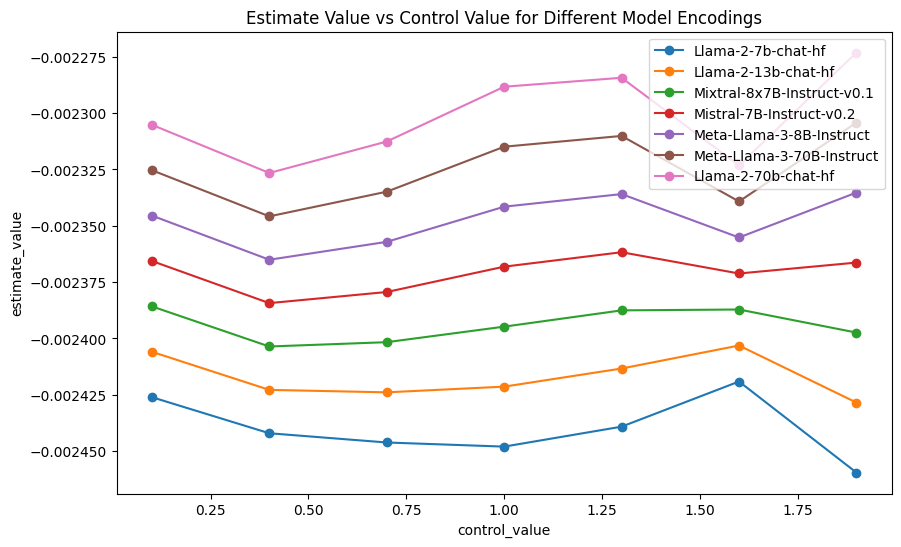

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

model_map = {
    0: "Llama-2-7b-chat-hf",
    1: "Llama-2-13b-chat-hf",
    2: "Mixtral-8x7B-Instruct-v0.1",
    3: "Mistral-7B-Instruct-v0.2",
    4: "Meta-Llama-3-8B-Instruct",
    5: "Meta-Llama-3-70B-Instruct",
    6: "Llama-2-70b-chat-hf",
}

grouped = result_df.groupby("model_encoded")

plt.figure(figsize=(10, 6))

for name, group in grouped:
    plt.plot(
        group["control_value"],
        group["estimate_value"],
        label=model_map[name],
        marker="o",
    )
    # plt.fill_between(group['control_value'], group['lower_bound'], group['upper_bound'], alpha=0.01)

plt.legend()

plt.xlabel("control_value")
plt.ylabel("estimate_value")
plt.title("Estimate Value vs Control Value for Different Model Encodings")

plt.show()

In [56]:
refuter_list = ["bootstrap_refuter", "placebo_treatment_refuter"]

ref = model.refute_estimate(
    estimand=identified_estimand,
    estimate=dml_estimate,
    method_name="placebo_treatment_refuter",
)

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when 

In [57]:
print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.0022732615177913917
New effect:0.0
p value:1.0

